## Read time series data and split

In [12]:
import pandas as pd
import numpy as np
import jax

# Disable JIT compilation
#jax.config.update("jax_disable_jit", True)
#jax.config.update("jax_log_compiles", True)

import jax.numpy as jnp
import discretize_func as discretize
import tokenizer_func as tokenizer
import inference_func as inference
import pickle
import matplotlib.pyplot as plt

In [2]:
import os
from pathlib import Path

# Read
df = pd.read_parquet(Path("../data") / "dehli.parquet")

# Fill nans with nearest
df = df.ffill()

# Downsample from 5-min resolution to hourly
#df = df.resample("h").mean()

# Downsample from 5-min resolution to quarterly
df = df.resample("15min").mean()

# Change to numeric index (remove datetime)
#df = df.reset_index(drop=True)

# Fill nans with nearest
df = df.ffill()

# Columns of interest
cols = ['Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']
df = df[cols]

# Split in train/test
split_idx = int(len(df) * 0.8)
X = df.iloc[:split_idx].copy()
Y = df.iloc[split_idx:].copy()

## Pre-processing

* Normalize
* Delta tokens by derivation
* Global discretization

Current setup:
* delta tokens
* n_bins = 1024
* fixed size bins

Future:
* discretize each column individually
* quantile-based bins (centered at 0)

## Tokenize
* Tokenize each row: Channel+Value (on change), special time step token: 0

Token layout

* 0	BOS (beginning of sequence / row)
* CH_0 … CH_6  →  IDs 2 … 8 (channel tokens)
* DATA ≥ DATA_OFFSET = 2 + N_CHANNELS = 9 (data tokens)
* 1	EOS (end of row)

Example:

```python
[BOS,
 CH_0, DATA(x0),
 CH_1, DATA(x1),
 ...
 CH_6, DATA(x6),
 EOS]
```

# Read model

In [3]:
# Load model
with open('../models/token_model_20251222_140751.pkl', 'rb') as f:
    model_file = pickle.load(f)

globals().update(model_file)
ZERO_BIN = int(np.argmin(np.abs(mids)))

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.title('Loss')
plt.show()

## Autoregressive rollout
* Feed in test_tokens context window (same context +1 out)
* Generate one new token, add to context, adhere to grammar
* When a new full sparse frame is complete, [BOS, CH+DATA.., EOS], we make a new row
* Stop when we have stepped block_size (context window size)
* We should now have a dataframe of new deltas

TODO A later test would be to make new test_tokens with minimal columns and see if the model propose covariates.

In [4]:
rng_key = jax.random.PRNGKey(128)

In [5]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(jax.random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens]#.reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()
X_test_nv = X_test_normalized.values.astype(np.float32)   # (N, D)

# Discretize
X_test_tok = discretize.encode_equal_width_global(jnp.asarray(X_test_nv), edges)
test_tokens = tokenizer.encode_with_channels_sparse(X_test_tok, n_channels, ZERO_BIN)
token_stream = test_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(test_tokens))
print("Context window:", block_size)
print("Last context tokens:", token_stream)

Number of tokens: 2904
Context window: 480
Last context tokens: [1957    3 2001    4 1866    5 1824    6 1970    7 2173    8 1977    1
    0    2 1956    1    0    2 1965    1    0    2 1963    1    0    2
 1958    3 1984    4 1949    5 1924    6 1895    7 1590    8 1894    1
    0    2 1966    1    0    2 1940    1    0    2 1954    1    0    2
 1958    3 1979    5 1933    6 1970    7 2091    1    0    2 1990    1
    0    2 1974    1    0    2 1980    1    0    2 1977    3 1910    4
 1924    5 1961    6 2065    7 2091    8 1961    1    0    2 1963    1
    0    2 1966    1    0    2 1954    1    0    2 1946    3 1883    4
 2007    5 2052    6 1819    8 1910    1    0    2 1933    1    0    2
 1937    1    0    2 1938    1    0    2 1938    4 2013    5 2015    6
 1914    7 1812    1    0    2 1941    1    0    2 1926    1    0    2
 1937    1    0    2 1932    3 1957    4 2007    5 2006    8 1977    1
    0    2 1939    1    0    1    0    1    0    1    0    1    0    1
    0    1   

In [6]:
rng_key, subkey = jax.random.split(rng_key)

new_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=token_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [7]:
# Warmup, 
# * 5 minutes on Mac CPU
inference.decode_with_channels_stream(
    jnp.zeros((512,), dtype=jnp.int32),
    n_channels,
)

(Array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32),
 Array(0, dtype=int32, weak_type=True))

In [8]:
# Convert from stream to channel matrix
tokens_padded = inference.pad_tokens(new_tokens)
rows, n = inference.decode_with_channels_stream(tokens_padded, n_channels)
new_Y_tok = rows[:n]
new_Y_tok

Array([[1936,    0,    0,    0,    0,    0,    0],
       [ 471,    0,    0,    0,    0,    0,    0],
       [   0, 1921,    0,    0,    0,    0,    0],
       [1891,    0, 1976,    0,    0,    0,    0],
       [1778,    0, 3978,    0,    0, 2152,    0],
       [   0,    0,    0,    0, 1508,    0,    0],
       [1967,    0,    0,    0,    0,    0,    0],
       [1970,    0,    0,    0,    0,    0,    0],
       [1966,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1961,    0,    0],
       [1936,    0, 2098,    0,    0,    0,    0],
       [   0,    0,    0,    0, 1961,    0,    0],
       [   0,    0, 1998,    0,    0,    0,    0],
       [   0, 2082,    0,    0,    0,    0,    0],
       [ 112,    0,    0,    0,    0,    0,    0],
       [1946,    0,    0,    0,    0,    0,    0],
       [1956,    0,    0,    0,    0, 1904,    0],
       [   0,    0,    0,    0, 2017,    0,    0],
       [   0, 1952,    0,    0,    0,    0,    0],
       [1933,    0,    0,    0,

Delta model, so mu is not added back

$$
\frac{(x_t - \mu) - (x_{t-1} - \mu)}{\sigma}
\quad\equiv\quad
\frac{x_t - x_{t-1}}{\sigma}
$$

In [9]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_rec = discretize.decode_equal_width_global(new_Y_tok, mids)
Y_rec = pd.DataFrame(Y_rec, columns=X_test_normalized.columns)
#Y_rec = Y_rec * sigma # delta model so mu is not added back

init_values = X_test.iloc[-1].values
Y_pred = init_values + jnp.cumsum(Y_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_rec)]
Y_pred = pd.DataFrame(Y_pred, columns=X_test_normalized.columns, index=Y_test.index)
Y_pred

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2024-02-08 10:15:00,5545.324219,13.000000,11.100000,88.000000,270.000000,22.299999,1021.000000
2024-02-08 10:30:00,5538.730957,13.000000,11.100000,88.000000,270.000000,22.299999,1021.000000
2024-02-08 10:45:00,5538.730957,12.903341,11.100000,88.000000,270.000000,22.299999,1021.000000
2024-02-08 11:00:00,5538.500000,12.903341,11.249761,88.000000,270.000000,22.299999,1021.000000
2024-02-08 11:15:00,5537.762695,12.903341,20.369175,88.000000,270.000000,23.238300,1021.000000
...,...,...,...,...,...,...,...
2024-02-09 12:30:00,5531.938477,25.977421,6.428010,87.759972,268.127808,23.033451,1015.624146
2024-02-09 12:45:00,5531.882324,25.977421,6.428010,87.759972,268.127808,23.033451,1015.624146
2024-02-09 13:00:00,5532.569824,25.977421,6.428010,87.759972,268.127808,23.033451,1015.624146


In [10]:
Y_test

,Power demand,temp,dwpt,rhum,wdir,wspd,pres
datetime,,,,,,,
2024-02-08 10:15:00,5633.276667,13.0,11.1,88.0,270.0,22.3,1021.0
2024-02-08 10:30:00,5870.980000,15.0,8.9,67.0,280.0,14.8,1021.0
2024-02-08 10:45:00,6013.676667,15.0,8.9,67.0,280.0,14.8,1021.0
2024-02-08 11:00:00,6038.546667,15.0,8.9,67.0,280.0,14.8,1021.0
2024-02-08 11:15:00,6133.943333,15.0,8.9,67.0,280.0,14.8,1021.0
...,...,...,...,...,...,...,...
2024-02-09 12:30:00,5672.750000,20.0,4.9,37.0,300.0,9.4,1021.0
2024-02-09 12:45:00,5684.430000,20.0,4.9,37.0,300.0,9.4,1021.0
2024-02-09 13:00:00,5587.920000,20.0,4.9,37.0,300.0,9.4,1021.0


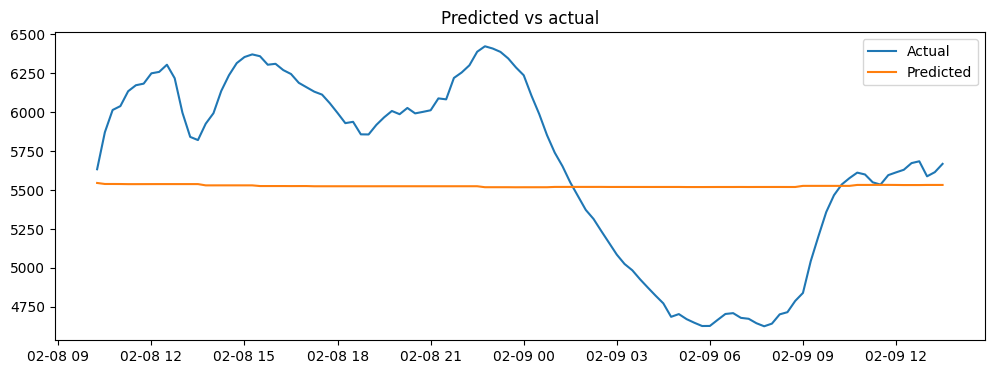

In [14]:
col = 'Power demand'
#col = "rhum"
#col = "temp"
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_pred.index, Y_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()

## Autoregressive channel hinter

Lets mask away some channels and see if the model hints about the missing channels.

In [ ]:
rng_key, subkey = jax.random.split(rng_key)
max_new_tokens = 480
t = int(random.randint(rng_key, shape=(), minval=0, maxval=len(X)-(3*max_new_tokens)))

# Select a random batch (t)
X_test = X.iloc[t:t+max_new_tokens]
Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+max_new_tokens].reset_index(drop=True)

# Pre-process it
X_test_normalized = (X_test-mu)/sigma
X_test_normalized = X_test_normalized.diff().dropna()

# Mask out channel 1, 4->
n_cols = X_test_normalized.shape[1]
mask = np.ones(n_cols, dtype=bool)
mask[[0]] = False
mask[2:] = False

X_masked = X_test_normalized.copy()
X_masked.loc[:, ~mask] = 0

X_masked_nv = X_masked.values.astype(np.float32)   # (N, D)

# Discretize
X_masked_tok = discretize.encode_equal_width_global(jnp.asarray(X_masked_nv), edges)
masked_tokens = tokenizer.encode_with_channels_sparse(X_masked_tok, n_channels, ZERO_BIN)
masked_stream = masked_tokens[-block_size:] # B, T

# Inspect first few tokens
print("Number of tokens:", len(masked_tokens))
print("Context window:", block_size)
print("Last context tokens:", masked_stream)

In [ ]:
X_masked

In [ ]:
new_masked_tokens = inference.generate_continue(
    variables,
    model.apply,
    token_stream=masked_stream,
    rng_key=rng_key,
    vocab_size=vocab_size,
    block_size=block_size,
    max_new_tokens=max_new_tokens,
    n_channels=n_channels,
)

In [ ]:
# Decode from sparse to all channels
new_masked_tok = inference,decode_with_channels_stream(new_masked_tokens, n_channels)

In [ ]:
# Decode tokens to deltas, cumsum with initial value, and de-normalize
Y_masked_rec = discretize.decode_equal_width_global(new_masked_tok, mids)
Y_masked_rec = pd.DataFrame(Y_masked_rec, columns=X.columns)
Y_masked_rec = Y_masked_rec * sigma # delta model so mu is not added back

pd.DataFrame(Y_masked_rec)


In [ ]:
# Cumsum
init_values = X_test.iloc[-1].values
Y_masked_pred = init_values + jnp.cumsum(Y_masked_rec.values, axis=0)

Y_test = X.iloc[t+max_new_tokens:t+max_new_tokens+len(Y_masked_pred)]
Y_masked_pred = pd.DataFrame(Y_masked_pred, columns=X.columns, index=Y_test.index)

Y_masked_pred

In [ ]:
#col = 'Power demand'
col = 'temp'
plt.figure(figsize=(12, 4))
plt.plot(Y_test.index, Y_test[col], label="Actual")
plt.plot(Y_masked_pred.index, Y_masked_pred[col], label="Predicted")
plt.title('Predicted vs actual')
plt.legend()
plt.show()